# FPP optimization workflow 

In [1]:
using Revise
using FUSE
using Plots
FUSE.logging(Logging.Info; actors=Logging.Debug);

┌ Error: Error during loading of extension NLoptMathOptInterfaceExt of NLopt, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    InitError: Creating a new global in closed module `NLopt` (`Optimizer`) breaks incremental compilation because the side effects will not be permanent.
│    Stacktrace:
│      [1] __init__()
│        @ NLoptMathOptInterfaceExt ~/.julia/packages/NLopt/1EJXl/ext/NLoptMathOptInterfaceExt.jl:17
│      [2] run_module_init(mod::Module, i::Int64)
│        @ Base ./loading.jl:1128
│      [3] register_restored_modules(sv::Core.SimpleVector, pkg::Base.PkgId, path::String)
│        @ Base ./loading.jl:1116
│      [4] _include_from_serialized(pkg::Base.PkgId, path::String, ocachepath::String, depmods::Vector{Any})
│        @ Base ./loading.jl:1061
│      [5] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String, build_id::UInt128)
│        @ Base ./loading.jl:1575
│      [6] _require(pkg::Base.PkgId, env::Nothing

## Make new FPP equilibirum from scratch

### Initialize from FPP v1_demount

In [2]:
ini, act = FUSE.case_parameters(:FPP, version=:v1_demount, init_from=:scalars);

### Modify ini

In [3]:
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 0.8826 # set less than one so that init uses this as the f_kappa parameter
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0
ini.equilibrium.pressure_core = 1.5e6

delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 0.825
ini.core_profiles.greenwald_fraction = missing
ini.core_profiles.ne_ped = missing
ini.core_profiles.greenwald_fraction_ped = 0.9
ini.core_profiles.ne_coreped_ratio = 1.25
ini.core_profiles.helium_fraction = 0.04
ini.core_profiles.zeff = 2.0

ini.build.plasma_gap = 0.125
ini.equilibrium.xpoints = :lower
ini.build.divertors = :lower
ini.build.symmetric = false

ini.ec_launchers.power_launched = 20e6

ini.pf_active.n_coils_outside = 8

8

In [4]:
function my_workflow(ini::FUSE.ParametersInits, act::FUSE.ParametersActors)

    ### modify ini layers
    
    R0 = ini.equilibrium.R0
    ϵ = ini.equilibrium.ϵ
    a = R0 * ϵ

    RiPlasma = R0 - a
    
    # HFS layers

    ini.build.layers[:plasma] = 2*a*(1+ini.build.plasma_gap)
    ini.build.layers[:hfs_first_wall] = 0.02
    ini.build.layers[:hfs_blanket] = 0.55*((1/ϵ-1.8)/2.2)^0.5
    ini.build.layers[:hfs_high_temp_shield] = RiPlasma*0.05
    ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.02
    ini.build.layers[:hfs_vacuum_vessel] = RiPlasma * 0.05
    ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
    ini.build.layers[:hfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
    ini.build.layers[:hfs_gap_low_temp_shield_TF] = RiPlasma * 0.02

    rbCenterPost = (R0 - 0.5*ini.build.layers[:plasma] - ini.build.layers[:hfs_first_wall] - ini.build.layers[:hfs_blanket]
        - ini.build.layers[:hfs_high_temp_shield] - ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel]
        - ini.build.layers[:hfs_vacuum_vessel] - ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield]
        - ini.build.layers[:hfs_low_temp_shield] - ini.build.layers[:hfs_gap_low_temp_shield_TF]);

    ini.build.layers[:hfs_TF] = rbCenterPost * 0.25
    ini.build.layers[:OH] = rbCenterPost * 0.25
    ini.build.layers[:gap_TF_OH] = RiPlasma * 0.02
    ini.build.layers[:gap_OH] = rbCenterPost - ini.build.layers[:hfs_TF] - ini.build.layers[:gap_TF_OH] - ini.build.layers[:OH]

    # LFS layers

    ini.build.layers[:lfs_first_wall] = 0.02
    ini.build.layers[:lfs_blanket] = 1.0 - 0.25*((1/ϵ-2.1)/1.9)^0.5
    ini.build.layers[:lfs_high_temp_shield] = RiPlasma * 0.05
    ini.build.layers[:lfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.2
    ini.build.layers[:lfs_vacuum_vessel] = RiPlasma * 0.05
    ini.build.layers[:lfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
    ini.build.layers[:lfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
    ini.build.layers[:lfs_gap_low_temp_shield_TF] = RiPlasma * 0.02
    ini.build.layers[:lfs_TF] = ini.build.layers[:hfs_TF]
    
    ### Split EC power 33%/66% between on-axis and off-axis deposition
    
    #ini.ec_launchers.power_launched = [1. /3. *ini.ec_launchers.power_launched, 2. /3. *ini.ec_launchers.power_launched]
    
    ### run init
    
    dd = FUSE.init(ini, act)
    
    ### run main compound actor
    
    FUSE.ActorWholeFacility(dd, act)
    
    return dd
end


my_workflow (generic function with 1 method)

### Modify act

In [5]:
act.ActorEquilibrium.model = :Solovev
act.ActorEquilibrium.symmetrize = false

act.ActorECsimple.rho_0 = 0.6
act.ActorECsimple.width = 0.05

act.ActorPedestal.update_core_profiles = false
act.ActorPedestal.only_powerlaw = false
act.ActorPedestal.T_ratio_pedestal = 1.0

act.ActorHFSsizing.do_plot = true
act.ActorHFSsizing.verbose = true
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.error_on_technology = false
act.ActorHFSsizing.error_on_performance = false
act.ActorFluxSwing.operate_oh_at_j_crit = true

act.ActorPFcoilsOpt.do_plot = false
act.ActorPFcoilsOpt.update_equilibrium = false
act.ActorPFcoilsOpt.optimization_scheme = :none

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.2

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorStabilityLimits.raise_on_breach = false
act.ActorStabilityLimits.models = [:beta_troyon_1984, :model_201, :model_401] # include βn check

act.ActorCosting.model = :GASC
act.ActorCosting.production_increase = 10.0
act.ActorCosting.learning_rate = 0.616

act.ActorFixedProfiles.T_shaping = ini.core_profiles.T_shaping
act.ActorFixedProfiles.n_shaping = ini.core_profiles.n_shaping
act.ActorFixedProfiles.T_ratio_pedestal = 1.0
act.ActorFixedProfiles.T_ratio_core = ini.core_profiles.T_ratio

act.ActorCoreTransport.model = :FixedProfiles

act.ActorStationaryPlasma.convergence_error = 1e-2

0.01

### Set input params

In [6]:
# input values

ini.core_profiles.greenwald_fraction_ped = 0.7
ini.core_profiles.ne_coreped_ratio = 1.6
ini.equilibrium.B0 = 6.0
ini.equilibrium.ip = 8.5e6
ini.equilibrium.R0 = 5.0
ini.equilibrium.pressure_core = 1.6e6
ini.core_profiles.zeff = 1.5
ini.ec_launchers.power_launched = 20e6

# constraint values

ini.requirements.power_electric_net = 200.0e6
ini.requirements.flattop_duration =24*3600.0
ini.requirements.q95 = 3.0
ini.requirements.ne_peaking = 1.5;
ini.requirements.q_pol_omp = 3.0e9;
ini.requirements.lh_power_threshold_fraction = 1.0;
ini.requirements.hds03 = 1.0;
ini.requirements.coil_j_margin = 1.5;
ini.requirements.coil_stress_margin = 1.0;

## Run WholeFacility Actor

[ Info: Equilibrium


[ Info:  Solovev


[ Info: HCD
[ Info:  ECsimple


[ Info:  ICsimple
[ Info:  LHsimple


[ Info:  NBsimple


[ Info: SteadyStateCurrent


[ Info: CXbuild


[ Info: WholeFacility


[ Info:  StationaryPlasma


[ Info:  StabilityLimits


[ Info:  HFSsizing


[ Info:   FluxSwing
[ Info:   Stresses


[ Info:   FluxSwing


[ Info:   Stresses


(0.16170942075117067, [-3.853723609137274e-7, -0.0007214604054177654, -8.496335295186474e-5, -0.07474848024690178, -2.571961915982078e-5, 0.0], [0.0])
Optimization Result


  Iteration:       50
  Minimum:         0.161709
  Minimizer:       [0.283866, 0.173813, 0.760913, 0.79945]
  Function calls:  1000


  Feasibles:       20 / 20 in final population
  Total time:      3.3561 s


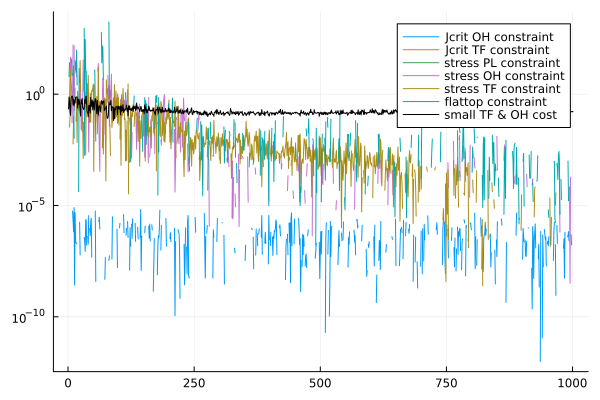

  Stop reason:     Maximum number of iterations exceeded.
[PL.thickness] = 

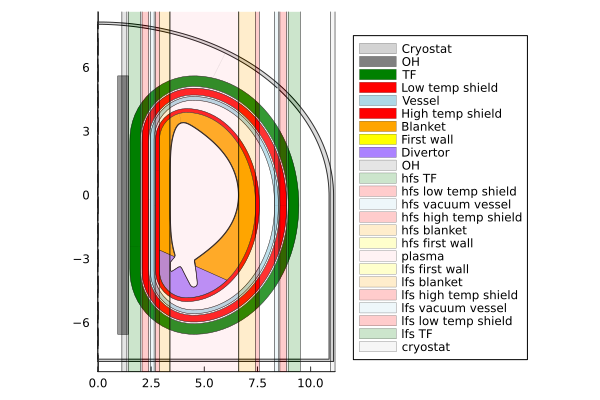

[1.1246074356953717]
[OH.thickness, dd.build.oh.technology.fraction_steel] = [0.23659432357503804, 0.7609125183382334]
[TFhfs.thickness, dd.build.tf.technology.fraction_steel] = [0.5678860749334202, 0.79945037900999]

target_B0 = 6.000200759479158
(dd.build.tf.max_b_field * TFhfs.end_radius) / R0 = 6.000517141303373

dd.build.oh.flattop_duration = 86652.58196705538
dd.requirements.flattop_duration = 86400.0
dd.build.oh.flattop_duration / dd.requirements.flattop_duration = 1.0029234023964742

dd.build.oh.max_j = 4.882456888370856e7
dd.build.oh.critical_j = 7.32823458095239e7
dd.build.oh.critical_j / dd.build.oh.max_j = 1.5009317539304732

dd.build.tf.max_j = 2.449086192573606e7
dd.build.tf.critical_j = 5.055928743656301e7
dd.build.tf.critical_j / dd.build.tf.max_j = 2.0644143758547395

maximum(cs.stress.vonmises.oh) = 7.708039484938966e8
cs.properties.yield_strength.oh = 8.0e8
cs.properties.yield_strength.oh / maximum(cs.stress.vonmises.oh) = 1.0378774026302677

maximum(cs.stress.vonmis

[ Info:  LFSsizing


[ Info:  CXbuild


[ Info:  PassiveStructures


[ Info:  Neutronics


[ Info:  Blanket


[ Info:   CXbuild


[ Info:  Divertors


[ Info:  BalanceOfPlant


[ Info:   HeatTransfer


[ Info:   ThermalCycle


[ Info:   PowerNeeds


[ Info:  Costing
[ Info:   GASCCosting
[ Info:    SheffieldCosting


422.907525 seconds (767.99 M allocations: 43.927 GiB, 5.68% gc time, 92.54% compilation time: <1% of which was recompilation)


In [7]:
@time dd = my_workflow(ini, act);

## Summary

In [8]:
println("oh.critical_j: ",dd.build.oh.critical_j)
println("oh.max_j: ", dd.build.oh.max_j)
println("tf.critical_j: ", dd.build.tf.critical_j)
println("tf.max_j: ",dd.build.tf.max_j)
println()
println("cs.stress.vonmises.oh: ", maximum(dd.solid_mechanics.center_stack.stress.vonmises.oh))
println("cs.stress.vonmises.tf: ", maximum(dd.solid_mechanics.center_stack.stress.vonmises.tf))

oh.critical_j: 7.32823458095239e7
oh.max_j: 4.882456888370856e7
tf.critical_j: 5.055928743656301e7
tf.max_j: 2.449086192573606e7

cs.stress.vonmises.oh: 7.708039484938966e8
cs.stress.vonmises.tf: 7.88062216718997e8


GEOMETRY                         EQUILIBRIUM                      TEMPERATURES                     DENSITIES                        
─────────────────────────────    ─────────────────────────────    ─────────────────────────────    ─────────────────────────────    


R0 → 5 [m]                       B0 → 6 [T]                       Te0 → 20.9 [keV]                 ne0 → 2.46e+20 [m⁻³]             
a → 1.43 [m]                     ip → 8 [MA]                      Ti0 → 17.2 [keV]                 ne_ped → 1.24e+20 [m⁻³]          
1/ϵ → 3.5                        q95 → 6.17                       <Te> → 8.84 [keV]                <ne> → 1.69e+20 [m⁻³]            
κ → 2.15                         <Bpol> → 0.668 [T]               <Ti> → 7.54 [keV]                ne0/<ne> → 1.45                  
δ → 0.713                        βpol_MHD → 2.98                  Te0/<Te> → 2.36                  fGW → 1.57                       
ζ → -0.0536                      βtor_MHD → 0.0392                Ti0/<Ti> → 2.28                  zeff_ped → 1.5                   
Volume → 378 [m³]                βn_MHD → 4.2                                                      <zeff> → 1.5                     
Surface → 431 [m²]                                                   

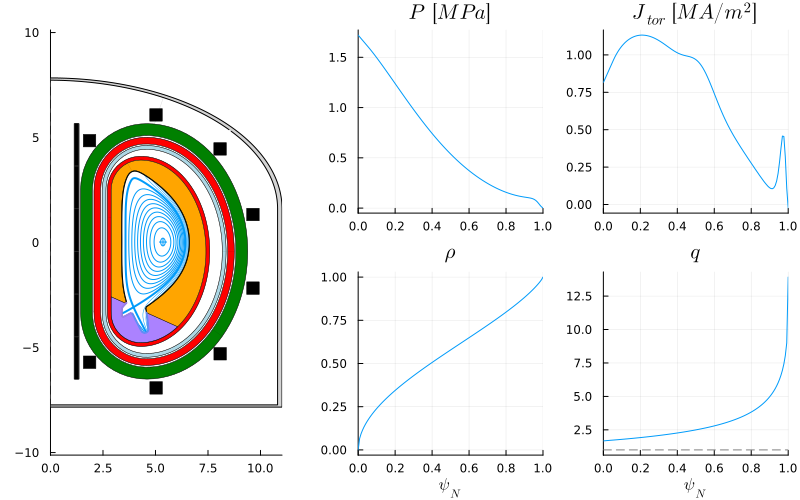

​


24×9 DataFrame
 Row │ group   details     type      ΔR         R_start   R_end     material      area       volume     
     │ String  String      String    Float64    Float64   Float64   String        Float64    Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            1.12461     0.0       1.12461                13.6779      48.3249
   2 │ in                  oh        0.236594    1.12461   1.3612   ReBCO          2.87755     22.472
   3 │ in                            0.0714548   1.3612    1.43266                 0.869061     7.62789
   4 │ hfs                 tf        0.567886    1.43266   2.00054  ReBCO         17.6739     222.157
   5 │ hfs                           0.0714548   2.00054   2.072                   2.10208     67.0876
   6 │ hfs     low temp    shield    0.318259    2.072     2.39026  Steel          8.87434    284.041
   7 │ hfs                           0.0714548   2.390

​


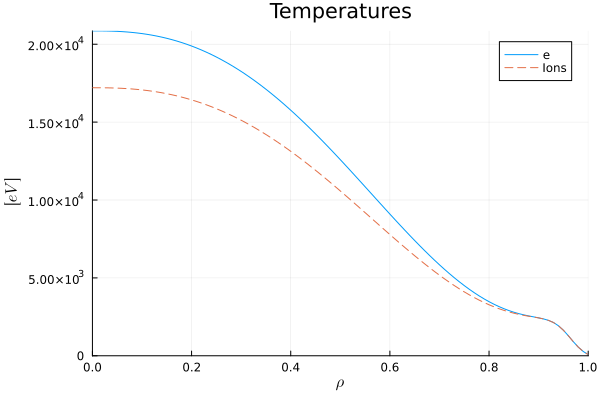

​


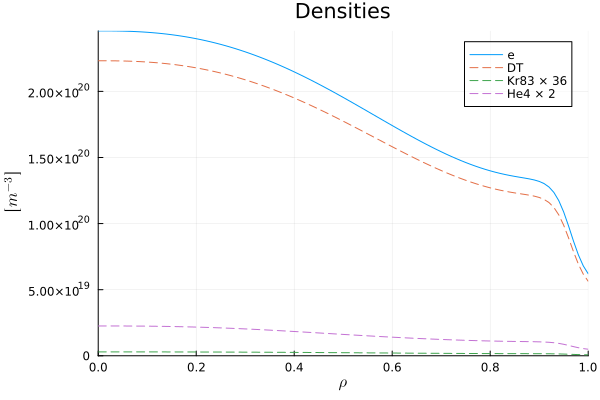

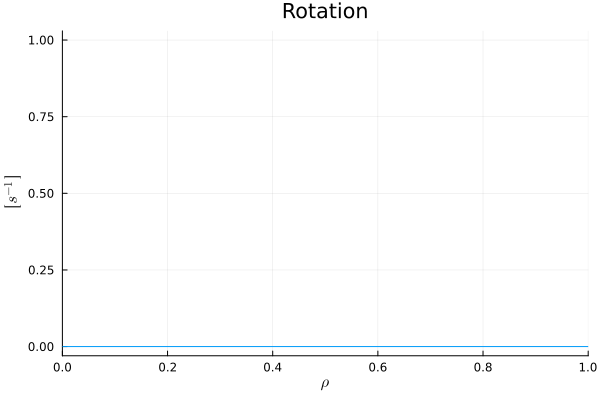

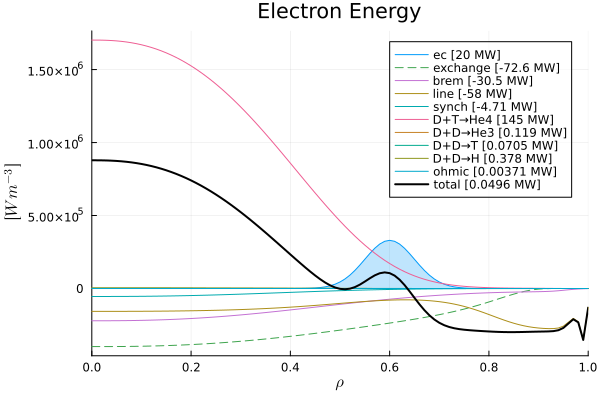

​
​
​


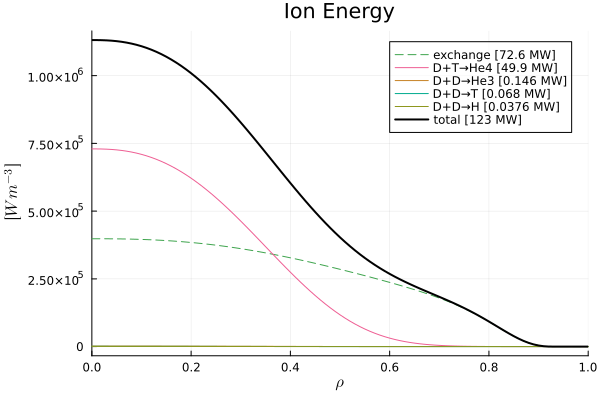

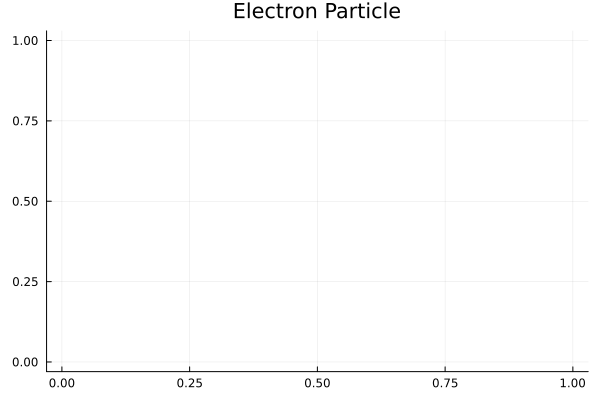

​
​


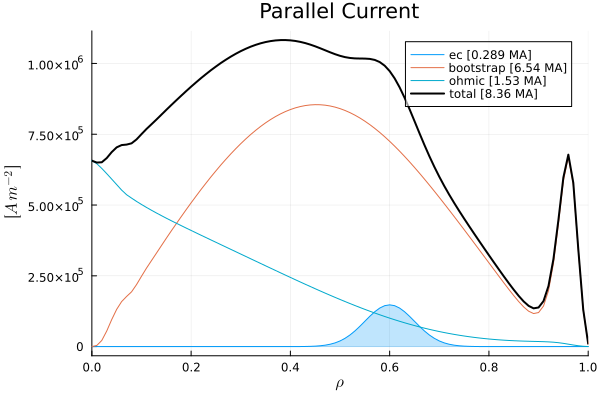

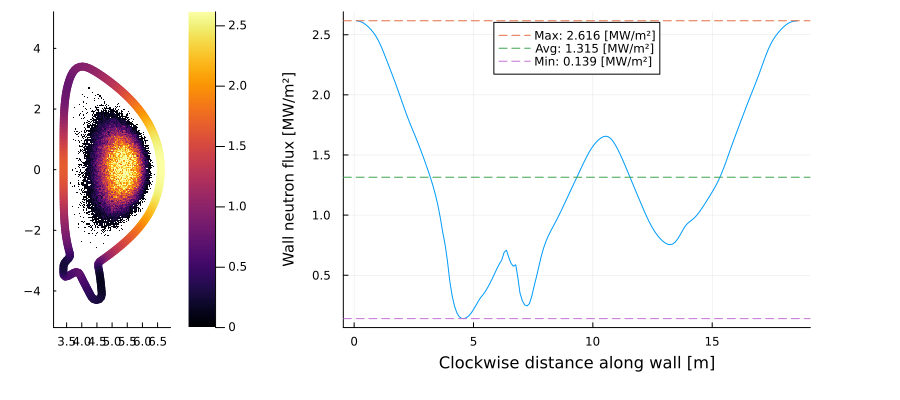

​
​


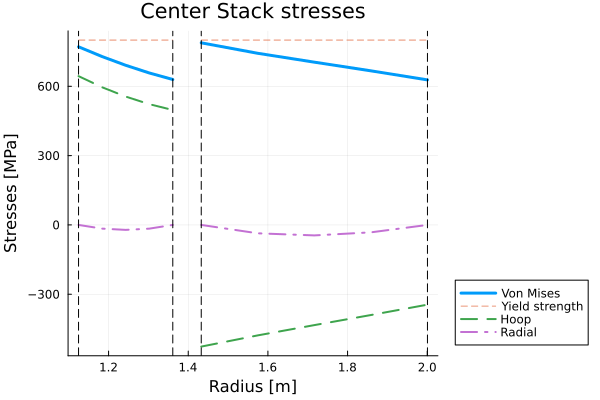

​


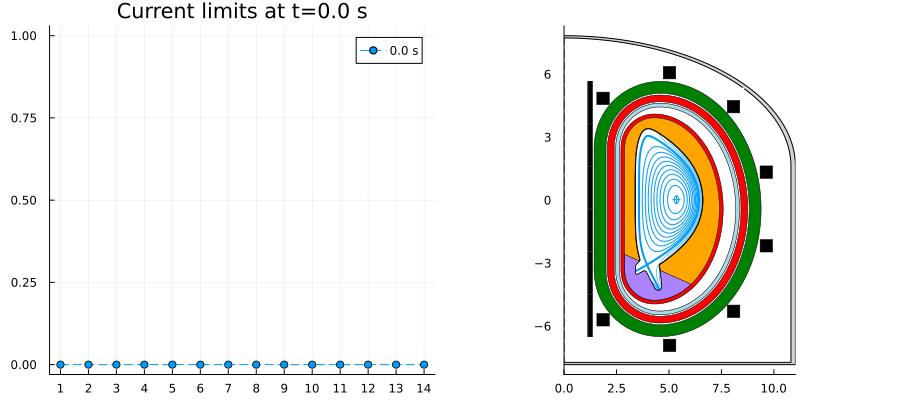

​


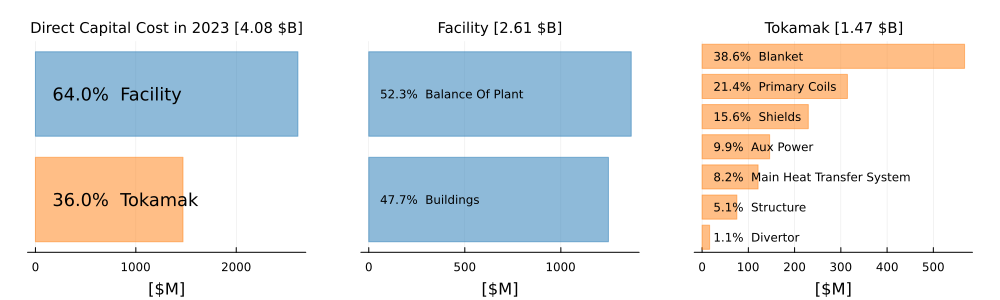

​


In [9]:
FUSE.digest(dd)

## Details

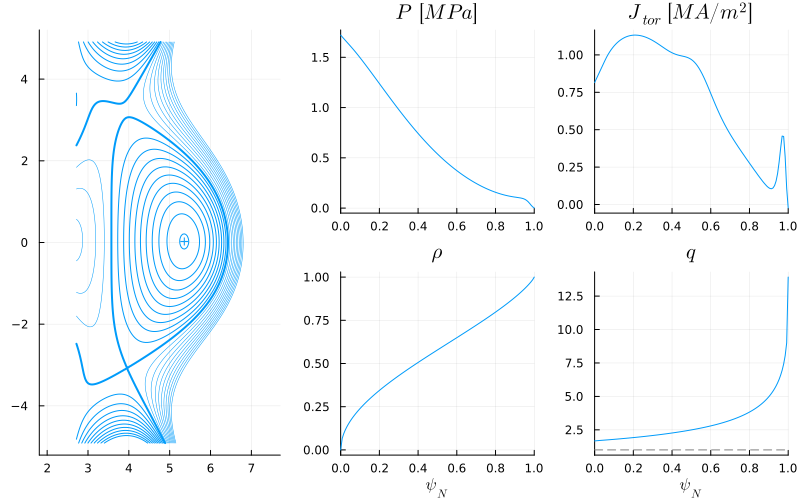

In [10]:
plot(dd.equilibrium)

In [11]:
dd.core_transport

core_transport
└─ vacuum_toroidal_field
   ├─ b0 ➡ Function [T]
   └─ r0 ➡ Function [m]


In [12]:
dd.blanket.module[].time_slice[]

maximum(@. sqrt(dd.neutronics.time_slice[].wall_loading.flux_r^2+dd.neutronics.time_slice[].wall_loading.flux_z^2))

2.616328632022821e6

In [13]:
dd.neutronics

neutronics
├─ first_wall
│  ├─ r ➡ 187-element Vector{Float64} [m]
│  └─ z ➡ 187-element Vector{Float64} [m]
├─ time ➡ [0] [s]
└─ time_slice
   └─ 1
      ├─ time ➡ 0 [s]
      └─ wall_loading
         ├─ flux_r ➡ 186-element Vector{Float64} [W/m^2]
         ├─ flux_z ➡ 186-element Vector{Float64} [W/m^2]
         └─ power ➡ 186-element Vector{Float64} [W]


In [14]:
dd.blanket

blanket
├─ module
│  └─ 1
│     ├─ layer
│     │  ├─ 1
│     │  │  ├─ material ➡ "Tungsten"
│     │  │  ├─ midplane_thickness ➡ 0.02 [m]
│     │  │  └─ name ➡ "lfs first wall"
│     │  ├─ 2
│     │  │  ├─ material ➡ "lithium-lead: Li6/7=46.882"
│     │  │  ├─ midplane_thickness ➡ 0.778061 [m]
│     │  │  └─ name ➡ "lfs blanket"
│     │  └─ 3
│     │     ├─ material ➡ "Steel, Stainless 316"
│     │     ├─ midplane_thickness ➡ 0.271497 [m]
│     │     └─ name ➡ "lfs high temp shield"
│     ├─ name ➡ "blanket"
│     └─ time_slice
│        └─ 1
│           ├─ peak_escape_flux ➡ 3.35251e+06 [W/m^2]
│           ├─ peak_wall_flux ➡ 1.08885e+07 [W/m^2]
│           ├─ power_incident_neutrons ➡ 7.50291e+08 [W]
│           ├─ power_incident_radiated ➡ 0 [W]
│           ├─ power_thermal_extracted ➡ 9.00349e+08 [W]
│           ├─ power_thermal_neutrons ➡ 9.00349e+08 [W]
│           ├─ power_thermal_radiated ➡ 0 [W]
│           ├─ time ➡ 0 [s]
│           └─ tritium_breeding_ratio ➡ 1.27532
├─ time 